First start the SLURM cluster and start a single job, that will use one SLURM task and 8 CPUs. Inside of this SLURM task will be 4 dask processes each using 2 cores

In [1]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=8,processes=4,project="notchpeak-shared-short",queue="notchpeak-shared-short",memory='8g')

from distributed import Client
from dask import delayed

cluster.start_workers(1)
client = Client(cluster)

Check what the SLURM job script looks like and show status of the client. You can see the job in the queue by running "squeue -u $USER" in a terminal window on the cluster interactive node.

In [2]:
print(cluster.job_script())
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p notchpeak-shared-short
#SBATCH -A notchpeak-shared-short
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=8G
#SBATCH -t 00:30:00
JOB_ID=${SLURM_JOB_ID%;*}



/uufs/chpc.utah.edu/common/home/u0101881/software/pkg/miniconda3/bin/python -m distributed.cli.dask_worker tcp://10.242.75.81:44763 --nthreads 2 --nprocs 4 --memory-limit 2.00GB --name dask-worker--${JOB_ID}-- --death-timeout 60



Client Scheduler: tcp://10.242.75.81:44763 Dashboard: http://10.242.75.81:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


Now let's define xarray sample dataset
You may need to "conda install matplotlib xarray" if you haven't done this already
And "conda install -c anaconda netcdf4", using the default channel is trying to get hdf5 from the Intel Python (as of 9/26/19)

In [6]:
%matplotlib inline

import xarray as xr

ds = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 25, 'lon': 25, 'time': -1})
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [8]:
da = ds['air']
da2 = da.groupby('time.month').mean('time')
da3 = da - da2

In [10]:
da_smooth = da.rolling(time=30).mean().persist()
da_smooth

<xarray.DataArray (time: 2920, lat: 25, lon: 53)>
dask.array<where, shape=(2920, 25, 53), dtype=float32, chunksize=(2905, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

CPU times: user 1.55 s, sys: 117 ms, total: 1.67 s
Wall time: 2.43 s


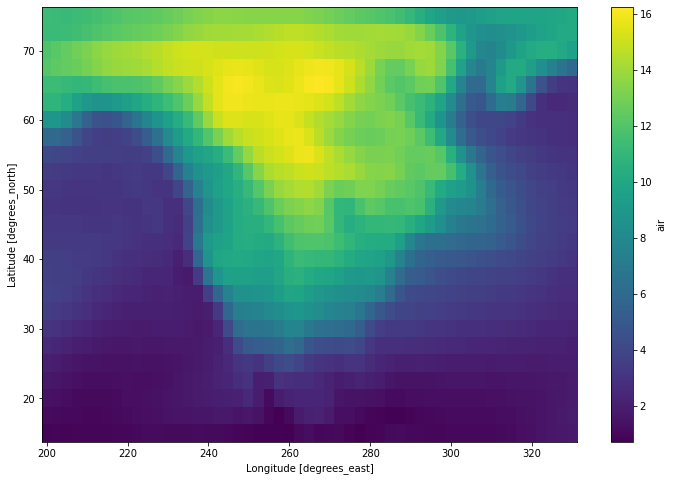

In [14]:
%time da.resample(time='1w').mean('time').std('time').load().plot(figsize=(12, 8))

In [15]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/common/home/u0101881/software/pkg/miniconda3/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/uufs/chpc.utah.edu/common/home/u0101881/software/pkg/miniconda3/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/common/home/u0101881/software/pkg/miniconda3/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/uufs/chpc.utah.edu/common/home/u0101881/software/pkg/miniconda3/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/uufs/chpc.utah.edu/com